## Initial EDA 

Specifications 

- 25 Million Rows
- 12 Features
    - Features are unknown for privacy reasons. Additionally, the are projected as to keep predictive power, while making it extremely difficult to deduce what they originally were. 
- 2 binary labels
    - Visits
    - Conversions
- Global Treatment Ratio: 84.6%



In [5]:
import google.datalab.bigquery as bq

query="""
SELECT COUNT(*) as total_rows
FROM `uplift.data`
"""


df = bq.Query(query).execute().result().to_dataframe()
df.head()

,total_rows
0,25309482


In [14]:
query="""
SELECT *
FROM `uplift.data`
ORDER BY RAND()
LIMIT 1000000
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,1.991981,3.263641,8.617092,3.735871,3.506733,10.161281,2.981721,-0.166689,-13.903629,15.995971,-1.8609,4.157648,1,0,0,0
1,-0.561010,3.263641,8.272483,3.735871,3.506733,10.161281,1.367787,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0,0,0
2,0.021456,3.263641,8.944919,2.773423,3.506733,10.161281,-2.931787,-0.166689,-7.569716,9.850093,-1.8609,4.157648,1,0,0,0
3,1.991981,3.263641,8.894464,3.735871,3.506733,10.161281,2.981721,-0.166689,-1.784858,9.850093,-1.8609,4.157648,0,0,0,0
4,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0,0,0


Above we can see each of the features (f0 - f11) are numeric and continous in nature. Below, we will look at some descriptive statistics for each feature. 

In [15]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.619580,3.265677,8.507953,3.656470,3.522720,10.201708,1.755504,-0.293643,-2.060825,10.671198,-2.095525,4.159091,0.846752,0.002275,0.041514,0.034716
std,1.535427,0.023321,0.359446,0.241653,0.109257,0.232673,1.673622,0.665434,5.474330,2.293606,1.393061,0.016990,0.360227,0.047643,0.199476,0.183060
min,-1.946280,3.263641,8.272483,1.119173,3.506733,10.161281,-7.895208,-4.724843,-32.887170,9.850093,-13.038111,4.157648,0.000000,0.000000,0.000000,0.000000
25%,-1.006548,3.263641,8.272483,3.735871,3.506733,10.161281,0.945163,-0.166689,-2.716012,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
50%,1.634821,3.263641,8.272483,3.735871,3.506733,10.161281,2.386066,-0.166689,1.107571,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
75%,1.991981,3.263641,8.759536,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
max,1.991981,4.502868,9.337055,3.735871,7.797549,16.905250,2.981721,-0.166689,1.107571,28.732895,-1.860900,5.194567,1.000000,1.000000,1.000000,1.000000


In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

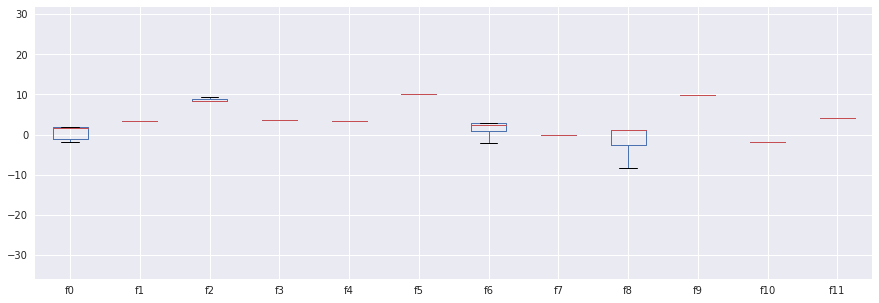

In [21]:
df.boxplot(column=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'])

In [ ]:
df[['treatment','conversion','visit', 'exposure']].plot.bar(rot=0)

1. Sanity Check 1
    - No users in the control population should be exposed to ads during the test.
    
   Confirmed with query below. 

In [16]:
query="""
SELECT COUNT(*) as treatment_and_exposure
FROM `uplift.data`
WHERE treatment = 0 AND exposure = 1
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,treatment_and_exposure
0,0


In [18]:
query="""
SELECT treatment, COUNT(*) AS cnt 
FROM `uplift.data`
GROUP BY treatment
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,treatment,cnt
0,1,21408827
1,0,3900655


2. Sanity Check Two
    - Features should be independent of treatment / control group. If not, there was a problem with the randomization strategy. 

In [26]:
query="""
SELECT * 
FROM (SELECT f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11, treatment FROM `uplift.data` a WHERE treatment = 1 ORDER BY RAND() LIMIT 2000)
UNION ALL  
SELECT *
FROM (SELECT f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11, treatment FROM `uplift.data` b WHERE treatment = 0 ORDER BY RAND() LIMIT 2000)
"""

query="""
SELECT f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11, treatment FROM `uplift.data` b ORDER BY RAND() LIMIT 20000
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment
0,1.790499,3.263641,8.419811,3.162731,4.013466,10.161281,-2.322957,-0.166689,-26.525624,24.587539,-9.276074,4.157648,1
1,-0.132765,3.263641,8.312902,3.581365,3.506733,10.161281,-0.073116,-0.166689,-15.420479,17.250467,-1.860900,4.157648,1
2,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648,1
3,-1.337604,3.263641,8.272483,3.735871,3.506733,10.161281,0.772132,-0.166689,1.107571,9.850093,-1.860900,4.157648,1
4,-1.363245,3.263641,8.272483,3.735871,3.506733,10.161281,2.386066,-0.166689,1.107571,9.850093,-1.860900,4.157648,1


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import hamming_loss
from scipy import stats

In [43]:
clf=LogisticRegression()
loss=hamming_loss
bootstraps=300

X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], df['treatment'], test_size=0.33, random_state=35)

y_pred = clf.fit(X_train, y_train).predict(X_test)
emp_loss = loss(y_test, y_pred)
bs_losses = []
y_bar = np.mean(df['treatment'])

for b in range(500+1):
    y_random = np.random.binomial(1, y_bar, size=df['treatment'].shape[0])
    X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], y_random)
    y_pred_bs = clf.fit(X_train, y_train).predict(X_test)
    bs_losses += [loss(y_test, y_pred_bs)]
    
pc = stats.percentileofscore(sorted(bs_losses), emp_loss) / 100.
pvalue = pc if pc < y_bar else 1 - pc

In [44]:
print(pc, pvalue)

(0.562874251497006, 0.562874251497006)


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

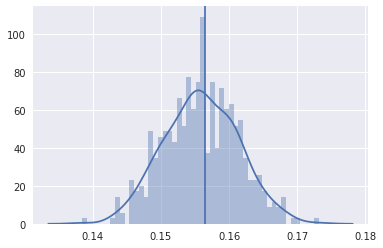

In [46]:
sns.distplot(bs_losses, bins=50)
plt.axvline(emp_loss)